In [1]:
%load_ext autoreload
%autoreload 2
from src.chem_draw import draw_rxn_svg, draw_pwy_svg
from src.utils import sort_x_by_y, ensure_dirs
from svgutils import compose as sc
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

In [2]:
# Params
expansion_dir = '../data/processed_expansions/'
fn = "ccm_v0_to_methylene_molecules_gen_4_tan_sample_1_n_samples_1000.pk" # Expansion file name
rxns_path = expansion_dir + 'predicted_reactions_' + fn
paths_path = expansion_dir + 'paths_' + fn

In [3]:
# Load reactions and paths
with open(rxns_path, 'rb') as f:
    pred_rxns = pickle.load(f)

with open(paths_path, 'rb') as f:
    paths = pickle.load(f)

In [4]:
# Count how many pathways have full info

for k,v in paths.items():
    n_paths_w_full_info = 0
    for p in v:
        path_full_info = []
        for rh in p.rhashes:
            full_info = False
            for elt in pred_rxns[rh].known_rxns:
                if elt[0] is not None:
                    full_info = True
                    break

            path_full_info.append(full_info)
        
        if all(path_full_info):
            n_paths_w_full_info += 1

    print(k, ":", n_paths_w_full_info / len(v), len(v))


('fumarate', '2-methyleneglutarate') : 0.2743835782825216 8233
('succinate', '2-methyleneglutarate') : 0.5875 1360
('malate', '2-methyleneglutarate') : 0.5496894409937888 322
('citrate', '2-methyleneglutarate') : 0.388646288209607 229
('pyruvate', '2-methyleneglutarate') : 0.42592592592592593 54
('oxaloacetate', '2-methyleneglutarate') : 0.95 20
('acetate', '2-methyleneglutarate') : 0.5714285714285714 14
('citrate', '4-methylene-l-glutarate') : 0.3557951482479784 371
('malate', '4-methylene-l-glutarate') : 0.8333333333333334 18
('oxaloacetate', '4-methylene-l-glutarate') : 0.34782608695652173 69
('fumarate', '4-methylene-l-glutarate') : 0.8620689655172413 29
('pyruvate', '4-methylene-l-glutarate') : 0.37735849056603776 53
('succinate', '4-methylene-l-glutarate') : 0.5 4


In [5]:
# Sort known reactions by average (could alter the sort by value)
for k in pred_rxns.keys():
    pred_rxns[k].sort_known_rxns()

In [6]:
# Set prc mcs attribute for each path by averaging over 
# known reactions
for st_pair in paths:
    for p in paths[st_pair]:
        p.compute_mean_prc_mcs(pred_rxns)

In [7]:
# # Sort paths by min reaction prc mcs
# min_prc_mcs = []
# for p in paths:
#     min_prc_mcs.append(p.min_mcs())

# min_sorted_idxs = np.arange(len(paths))

# min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

# plt.hist(min_prc_mcs)
# plt.show()

In [8]:
# # Sort paths by min reaction prc mcs
# mean_prc_mcs = []
# for p in paths:
#     mean_prc_mcs.append(p.mean_mcs())

# mean_sorted_idxs = np.arange(len(paths))

# mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(mean_sorted_idxs, mean_prc_mcs, reverse=True)

# plt.hist(mean_prc_mcs)
# plt.show()

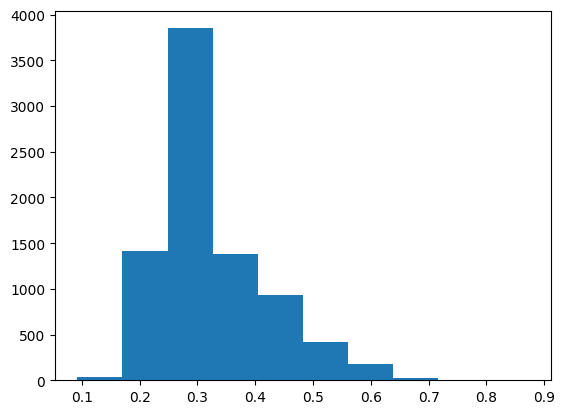

In [9]:
# First sort by min prc_mcs and threshold and then sort by mean prc_mcs

min_thresh = 0.05
st_pair = ('fumarate', '2-methyleneglutarate')

# Get min prc_mcs
min_prc_mcs = []
for p in paths[st_pair]:
    min_prc_mcs.append(p.min_mcs())

# Sort indices by min prc_mcs
min_sorted_idxs = np.arange(len(paths[st_pair]))
min_sorted_idxs, min_prc_mcs = sort_x_by_y(min_sorted_idxs, min_prc_mcs, reverse=True)

# Remove zero mins
min_sorted_idxs, min_prc_mcs = np.array(min_sorted_idxs), np.array(min_prc_mcs)
min_sorted_idxs = min_sorted_idxs[min_sorted_idxs > min_thresh]

# Get mean prc_mcs of non-zero min paths
mean_prc_mcs = []
for idx in min_sorted_idxs:
    mean_prc_mcs.append(paths[st_pair][idx].mean_mcs())

min_mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(min_sorted_idxs, mean_prc_mcs, reverse=True)

plt.hist(mean_prc_mcs)
plt.show()

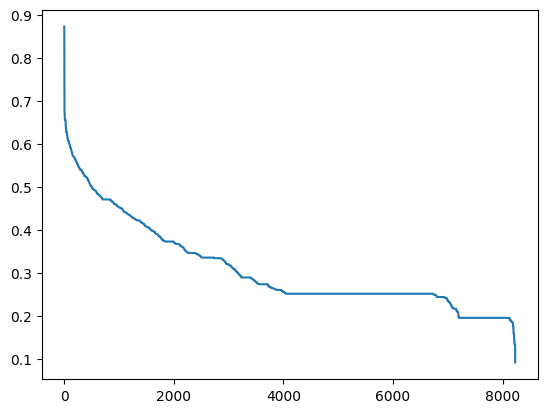

In [10]:
plt.plot(mean_prc_mcs)
plt.show()

In [53]:
# Generate pwy svgs

n_pwys = 20
pwy_svg_outdir = f"../artifacts/pwy_svgs/{fn[:-3]}/{'_'.join(st_pair)}/"
ensure_dirs(pwy_svg_outdir)

for i in range(n_pwys):
    pwy_idx = min_mean_sorted_idxs[i]
    sma_hash_pairs = []
    this_rhashes = paths[st_pair][pwy_idx].rhashes
    for this_rhash in this_rhashes:
        this_rxn = pred_rxns[this_rhash]
        sma_hash_pairs.append([(this_rxn.smarts, this_rhash), (this_rxn.known_rxns[0][1], hash(this_rxn.known_rxns[0][1]))])

    outpath = pwy_svg_outdir + f"{i:03}_{pwy_idx}.svg"
    draw_pwy_svg(sma_hash_pairs, outpath)

In [54]:
# Convert svgs to pdfs

tmp_pdf_outdir = f"../artifacts/tmp_pdfs/{fn[:-3]}/{'_'.join(st_pair)}/"
ensure_dirs(tmp_pdf_outdir)
for elt in os.listdir(pwy_svg_outdir):
    cmd = ["inkscape", f"--export-pdf={tmp_pdf_outdir}{elt[:-3]}pdf", f"{pwy_svg_outdir}{elt}"]
    subprocess.run(cmd)

Gtk-Message: 14:11:08.470: Failed to load module "gail"
Gtk-Message: 14:11:08.470: Failed to load module "atk-bridge"

(inkscape:41408): Gtk-WARNING **: 14:11:08.475: Unable to locate theme engine in module_path: "pixmap",

(inkscape:41408): Gtk-WARNING **: 14:11:08.476: Unable to locate theme engine in module_path: "adwaita",

(inkscape:41408): Gtk-WARNING **: 14:11:08.476: Unable to locate theme engine in module_path: "pixmap",

(inkscape:41408): Gtk-WARNING **: 14:11:08.476: Unable to locate theme engine in module_path: "pixmap",

(inkscape:41408): Gtk-WARNING **: 14:11:08.476: Unable to locate theme engine in module_path: "pixmap",

(inkscape:41408): Gtk-WARNING **: 14:11:08.477: Unable to locate theme engine in module_path: "pixmap",

(inkscape:41408): Gtk-WARNING **: 14:11:08.477: Unable to locate theme engine in module_path: "pixmap",

(inkscape:41408): Gtk-WARNING **: 14:11:08.477: Unable to locate theme engine in module_path: "pixmap",

(inkscape:41408): Gtk-WARNING **: 14:11:

In [55]:
# Concatenate pdfs
pwy_pdf_outdir = f"../artifacts/pwy_pdfs/{fn[:-3]}/"
ensure_dirs(pwy_pdf_outdir)
cat_pdf_fn = pwy_pdf_outdir + '_'.join(st_pair) + '.pdf'
individual_pwys = sorted(list(os.listdir(tmp_pdf_outdir)))
individual_pwys = [tmp_pdf_outdir + elt for elt in individual_pwys]
if cat_pdf_fn in individual_pwys:
    individual_pwys.remove(cat_pdf_fn)
cmd = ["pdfunite", *individual_pwys, cat_pdf_fn]
subprocess.run(cmd)

CompletedProcess(args=['pdfunite', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citrate_hopa/000_305.pdf', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citrate_hopa/001_145.pdf', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citrate_hopa/002_22.pdf', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citrate_hopa/003_50.pdf', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citrate_hopa/004_157.pdf', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citrate_hopa/005_37.pdf', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citrate_hopa/006_560.pdf', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citrate_hopa/007_437.pdf', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citrate_hopa/008_179.pdf', '../artifacts/tmp_pdfs/ccm_v0_to_hopa_gen_4_tan_sample_1_n_samples_1000/citra

### Example to explain PRC MCS

In [11]:
pr = pred_rxns[paths[st_pair][min_mean_sorted_idxs[0]].rhashes[2]]
pr_sma = pr.smarts
kr_sma = pr.known_rxns[0][1]

In [24]:
from src.rxn_ctr_mcs import atom_map
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import SVG

am_pr_sma = atom_map(pr_sma)
am_kr_sma = atom_map(kr_sma)

pr_rxn = AllChem.ReactionFromSmarts(am_pr_sma, useSmiles=True)
kr_rxn = AllChem.ReactionFromSmarts(am_kr_sma, useSmiles=True)
pr_rxn.Initialize()
kr_rxn.Initialize()

pr_ra = pr_rxn.GetReactingAtoms()
kr_ra = kr_rxn.GetReactingAtoms()

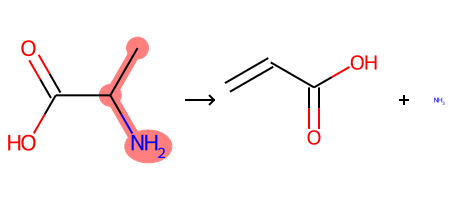

In [53]:
fn, _ = draw_rxn_svg(pr_sma, rhash='example_pred_rxn_ctr', hilite_atoms=[[0, 1, 2]])

with open(fn, 'r') as f:
    img = f.read()

SVG(img)

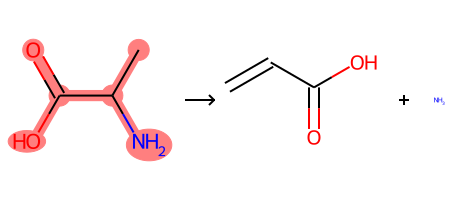

In [54]:
fn, _ = draw_rxn_svg(pr_sma, rhash='example_pred_mcs', hilite_atoms=[[0, 1, 2, 3, 4, 5]])

with open(fn, 'r') as f:
    img = f.read()

SVG(img)

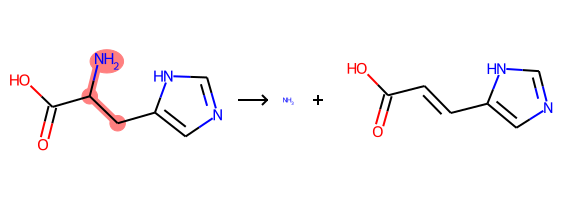

In [57]:
fn, _ = draw_rxn_svg(kr_sma, rhash='example_known_rxn_ctr', hilite_atoms=[[0, 1, 2]])

with open(fn, 'r') as f:
    img = f.read()

SVG(img)

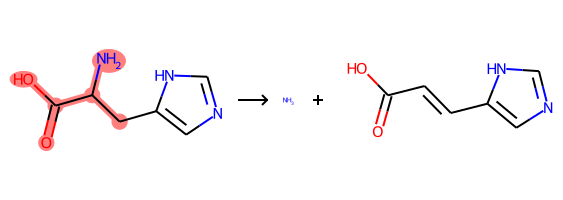

In [61]:
fn, _ = draw_rxn_svg(kr_sma, rhash='example_known_mcs', hilite_atoms=[[0, 1, 2, 8, 9, 10]])

with open(fn, 'r') as f:
    img = f.read()

SVG(img)

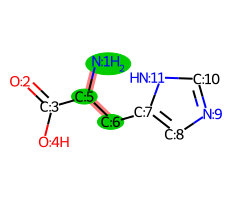

In [55]:
mol = kr_rxn.GetReactantTemplate(0)
Chem.SanitizeMol(mol)
hilite_atoms = list(kr_ra[0])
colors = {elt : (0, 0.8, 0) for elt in hilite_atoms}
nb = mol.GetNumAtoms()
width = int(np.log10(nb) * 200) + 25
d2d = Draw.MolDraw2DSVG(width, 200)


d2d.DrawMolecule(mol, highlightAtoms=hilite_atoms, highlightAtomColors=colors)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())